In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers
import time
import random
from sklearn.model_selection import train_test_split
from IPython import display
from tabulate import tabulate

In [ ]:
data = np.load('plume_sims.npy')
data.shape

(354, 120, 120)

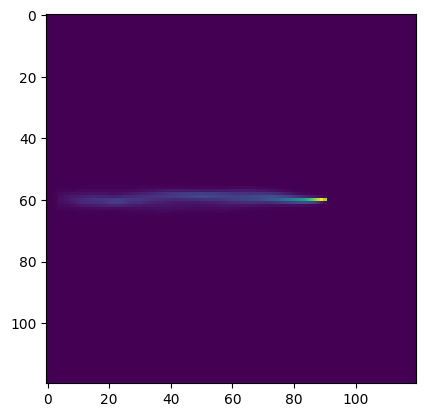

In [ ]:
plt.imshow(data[0])

In [ ]:
temp1111 = data.flatten()

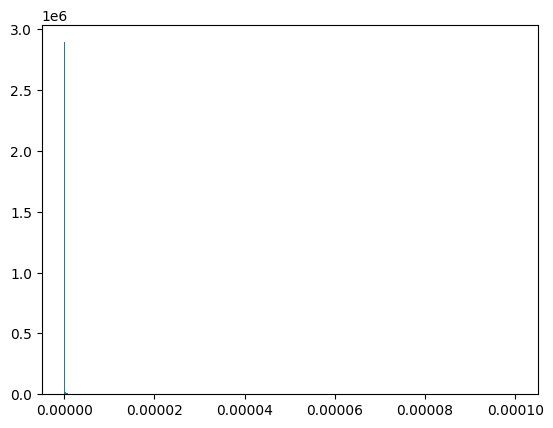

In [ ]:
plt.hist(temp1111, bins = 1000, range = (0, 0.0001))
plt.show() #not suitable for normalization

#Preprocessing

In [ ]:
data_reshape = data.reshape(data.shape[0], 120, 120, 1).astype('float32')
data_reshape = (data_reshape - 127.5) / 127.5  # Normalize to [-1, 1]
data_reshape.shape

(354, 120, 120, 1)

In [ ]:
#data augmentation
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(80, 80)
])

data_augmentation = tf.keras.Sequential([
  layers.RandomCrop(80,80),
  layers.RandomRotation(0.3)
])

label = np.ones(354)
train_images, X_test, y_train, y_test = train_test_split(data_reshape, label, test_size=0.2, random_state=9)
train_images.shape

(283, 120, 120, 1)

In [ ]:
#using augmentation to increase training data, while resizing test data but do not augment it
def prepare(data, augment=False):
  data = resize_and_rescale(data)

  if augment:
    data = data_augmentation(data, training = True)

  return data

temp = train_images.copy()
train_images = prepare(train_images)
for iter in range(10):
  train_images = np.append(train_images, prepare(temp, augment=True), axis = 0)

X_test = prepare(X_test)
train_images.shape

(3113, 80, 80, 1)

In [ ]:
BUFFER_SIZE = 3500 # more than # of data
BATCH_SIZE = 128

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE, reshuffle_each_iteration = True).batch(BATCH_SIZE,drop_remainder = True)

#DCGAN

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(20*20*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((20, 20, 256)))
    assert model.output_shape == (None, 20, 20, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 20, 20, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 40, 40, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 80, 80, 1)

    return model

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[80, 80, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator = make_generator_model()
discriminator = make_discriminator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00011257]], shape=(1, 1), dtype=float32)


In [ ]:
EPOCHS = 1000
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)

def generate_and_show_images(model, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
      plt.axis('off')
  plt.show()

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)
 
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #update generator and discriminator using computed gradient
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    display.clear_output(wait=True)
    generate_and_show_images(generator, seed)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  display.clear_output(wait=True)
  generate_and_show_images(generator, seed)

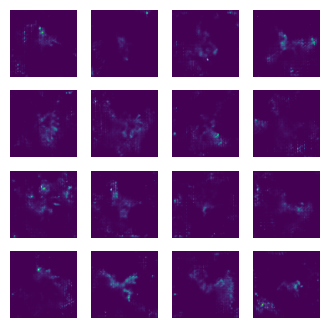

In [ ]:
EPOCHS = 1000
train(train_dataset, EPOCHS)

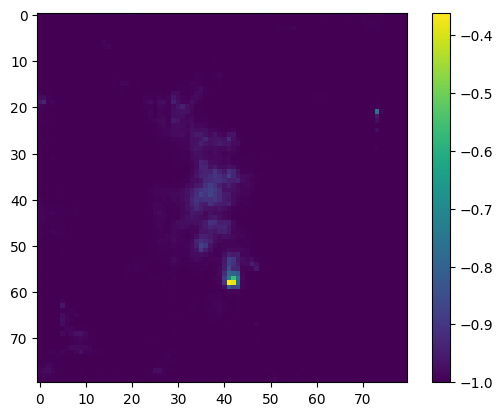

In [ ]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()

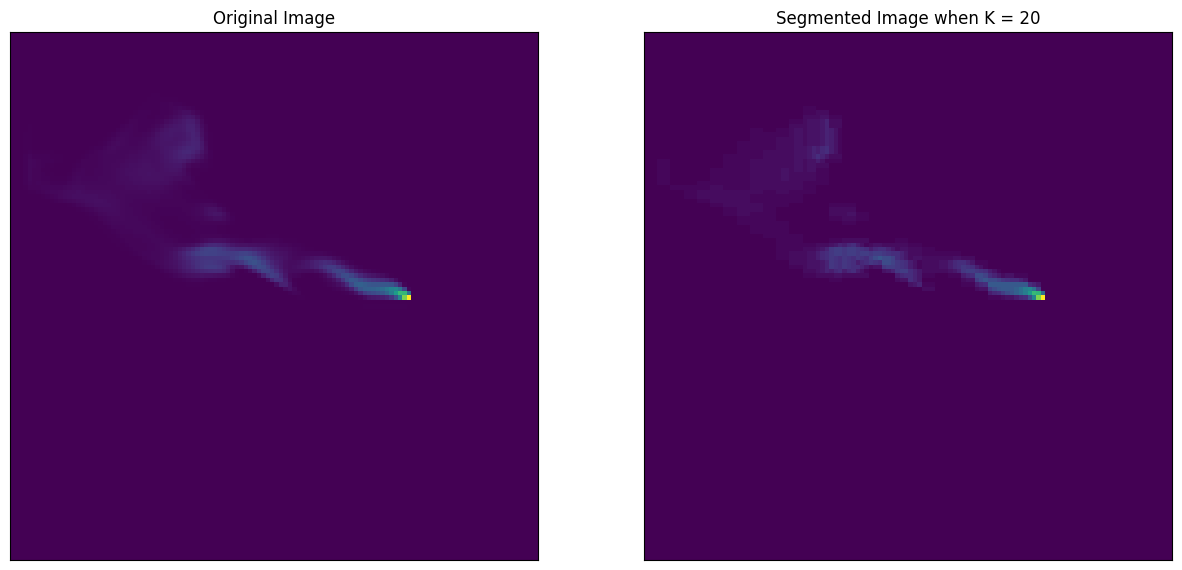

In [ ]:
#image segmentation: K means shows good result
import cv2

img = data[50]

vectorized = img.reshape((-1,3))
vectorized = np.float32(vectorized)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 20
attempts=10
ret,label,center=cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)

center = np.uint8(center)

res = center[label.flatten()]
result_image = res.reshape((img.shape))

figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(1,2,1),plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(result_image)
plt.title('Segmented Image when K = %i' % K), plt.xticks([]), plt.yticks([])
plt.show()

#Test discriminator as a classifier

In [ ]:
def generate_fake_images(n_samples):
    fake_imgs = tf.random.normal([n_samples, 80,80, 1])
    y_fake = np.zeros((n_samples, 1))
    return fake_imgs, y_fake

X_fake, y_fake = generate_fake_images(71)

X_fake_test = np.append(X_fake, X_test, axis = 0)

temp_y_test = y_test.reshape((71,1))
y_fake_test = np.append(y_fake, temp_y_test, axis = 0)

def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]
    
X_fake_test, y_fake_test = unison_shuffled_copies(X_fake_test, y_fake_test)

decision = discriminator(X_fake_test, training = False).numpy()
decision[decision > 0] = 1.
decision[decision < 0] = 0.

temp_decision = np.append(decision,y_fake_test, axis = 1)

In [ ]:
#show performance of the discriminator through precision, recall, f1 score
tp = 0
fn = 0
fp = 0

for x in temp_decision:
  if x[0] == x[1]:
    if x[0] == 1:
      tp += 1;
  elif x[0] == 0 and x[1] == 1:
    fn += 1;
  elif x[0] == 1 and x[1] == 0:
    fp += 1;
  else:
    next;

precision_dis = tp / (tp + fp)
recall_dis = tp / (tp + fn)
f1_score_dis = (2*tp) / (2*tp + fp + fn)

mydata = [ ['precision_dis', 'recall_dis', 'f1_score_dis'], [precision_dis, recall_dis, f1_score_dis] ]

print(tabulate(mydata))

-------------  ------------------  ------------------
precision_dis  recall_dis          f1_score_dis
1.0            0.6197183098591549  0.7652173913043478
-------------  ------------------  ------------------


#CNN as a classifier

In [ ]:
def CNN():
  model = tf.keras.Sequential()

  model.add(layers.Conv2D(16, (5,5), activation='relu', input_shape=(80, 80, 1)))
  model.add(layers.MaxPooling2D(2, 2))

  model.add(layers.Conv2D(32, (5,5), activation='relu'))
  model.add(layers.MaxPooling2D(2, 2))

  model.add(layers.Conv2D(64, (5,5), activation='relu'))
  model.add(layers.MaxPooling2D(2, 2))

  model.add(layers.Flatten())

  model.add(layers.Dense(256, activation='relu'))

  model.add(layers.Dense(1, activation='sigmoid'))

  opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

  return model

cnn = CNN()
cnn.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 76, 76, 16)        416       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 38, 38, 16)       0         
 2D)                                                             
                                                                 
 conv2d_17 (Conv2D)          (None, 34, 34, 32)        12832     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 17, 17, 32)       0         
 2D)                                                             
                                                                 
 conv2d_18 (Conv2D)          (None, 13, 13, 64)        51264     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 6, 64)       

In [ ]:
#generate "positive data"
cnn_data = generator(noise, training=False).numpy()
for iter in range(1000):
  noise = tf.random.normal([1, 100])
  cnn_data = np.append(cnn_data, generator(noise, training=False).numpy(), axis = 0)
cnn_data.shape

(1001, 80, 80, 1)

In [ ]:
#generate "negative data"
def generate_fake_images(n_samples):
    fake_imgs = tf.random.normal([n_samples, 80,80,1])
    y_fake = np.zeros((n_samples, 1))
    return fake_imgs, y_fake

X_fake, y_fake = generate_fake_images(1001)

X_fake_test = np.append(X_fake, cnn_data, axis = 0)

y_real = np.ones((1001,1))
y_fake_test = np.append(y_fake, y_real, axis = 0)

def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]
    
X_fake_test, y_fake_test = unison_shuffled_copies(X_fake_test, y_fake_test)

In [ ]:
y_fake_test[18]

array([1.])

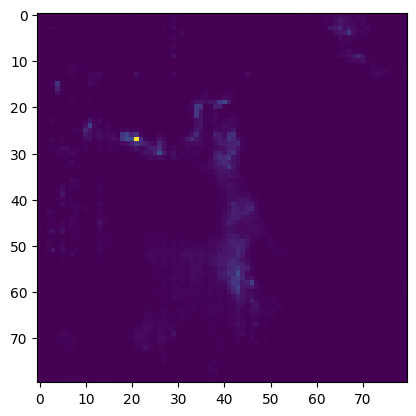

In [ ]:
plt.imshow(X_fake_test[18])

In [ ]:
#cnn train, val, and test set split
X_train, X_test, y_train, y_test = train_test_split(X_fake_test, y_fake_test, test_size=0.2, random_state=9)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=9)

In [ ]:
history = cnn.fit(X_train, y_train, epochs=10, 
                    validation_data=(X_val, y_val))

Epoch 1/10
40/40 [==============================] - 2s 15ms/step - loss: 0.1667 - accuracy: 0.9234 - precision_1: 1.0000 - recall_1: 0.8483 - val_loss: 0.0024 - val_accuracy: 1.0000 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 2/10
40/40 [==============================] - 0s 8ms/step - loss: 5.0414e-04 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - val_loss: 1.2487e-04 - val_accuracy: 1.0000 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 3/10
40/40 [==============================] - 0s 8ms/step - loss: 8.6098e-05 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - val_loss: 5.9119e-05 - val_accuracy: 1.0000 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 4/10
40/40 [==============================] - 0s 8ms/step - loss: 4.3978e-05 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - val_loss: 3.2412e-05 - val_accuracy: 1.0000 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 5/10
40/40 [==============================] - 0s 

In [ ]:
history.history

{'loss': [0.1666860282421112,
  0.0005041371332481503,
  8.609848009655252e-05,
  4.3977604946121573e-05,
  2.5170829758280888e-05,
  1.5842420907574706e-05,
  1.0791807653731667e-05,
  7.791035386617295e-06,
  5.7743295656109694e-06,
  4.323648227000376e-06],
 'accuracy': [0.9234374761581421, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'precision_1': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'recall_1': [0.8482972383499146, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'val_loss': [0.002426684834063053,
  0.00012487079948186874,
  5.911866173846647e-05,
  3.241191734559834e-05,
  1.9569415599107742e-05,
  1.2922181667818222e-05,
  9.110585779126268e-06,
  6.689790097880177e-06,
  5.005278580938466e-06,
  3.7599065763060935e-06],
 'val_accuracy': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'val_precision_1': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'val_recall_1': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}

In [ ]:
test_loss, test_acc, test_precision, test_recall = cnn.evaluate(X_test,  y_test, verbose=4)

In [ ]:
f1_score_cnn = (2 * test_precision * test_recall) / (test_precision + test_recall)
mydata_cnn = [ ['precision_cnn', 'recall_cnn', 'f1_score_cnn'], [test_precision, test_recall, f1_score_cnn] ]

print(tabulate(mydata_cnn))

-------------  ----------  ------------
precision_cnn  recall_cnn  f1_score_cnn
1.0            1.0         1.0
-------------  ----------  ------------
